In [1]:
import numpy as np
import pandas as pd
import plotnine as p9

import polygraph.input, polygraph.embedding, polygraph.motifs, polygraph.models, polygraph.sequence, polygraph.utils, polygraph.visualize, polygraph.stats, polygraph.likelihood

%matplotlib inline

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Tutorial on human data

### Read in data

In [2]:
seqs = pd.read_csv('human_seqs.txt')
seqs.head()

,Sequence,Group,K562_l2fc,MinGap,K562_lfcSE,K562_prediction,SeqID
0,GCTCGTGAGCCGTCAAGGATGCGCTCACCATCGAGCCACACGTTGG...,FastSeqProp,6.693819,11.262747,0.527668,6.363210,0
1,GTTCGCCCGCGCATGGAGCAACGCTCTCGTTAGGACGCTTTCGTCC...,FastSeqProp,6.488648,10.065946,0.611020,4.845627,1
2,TTTGACAGTTCCCGCCAAAATCGGACCTAGCCGTCTCAAGGCCGAG...,FastSeqProp,5.479217,9.571529,0.361232,5.632198,2
3,GCTCTTGACACGCGCGAACACGTTGAGTTTGAGCGGGACGAGATAG...,FastSeqProp,5.153645,9.568642,0.357879,8.558550,3
4,CCTCGATCATCTTGCACGGGTACCGGTAAGTCATGAGTGTAGCGCT...,FastSeqProp,4.641555,9.185362,0.684389,6.245122,4


In [3]:
print(seqs.Group.value_counts())

Group
FastSeqProp            2000
Simulated_Annealing    2000
AdaLead                2000
native                 2000
random                 2000
Name: count, dtype: int64


# 1. Sequence composition

## 1.1 GC Content

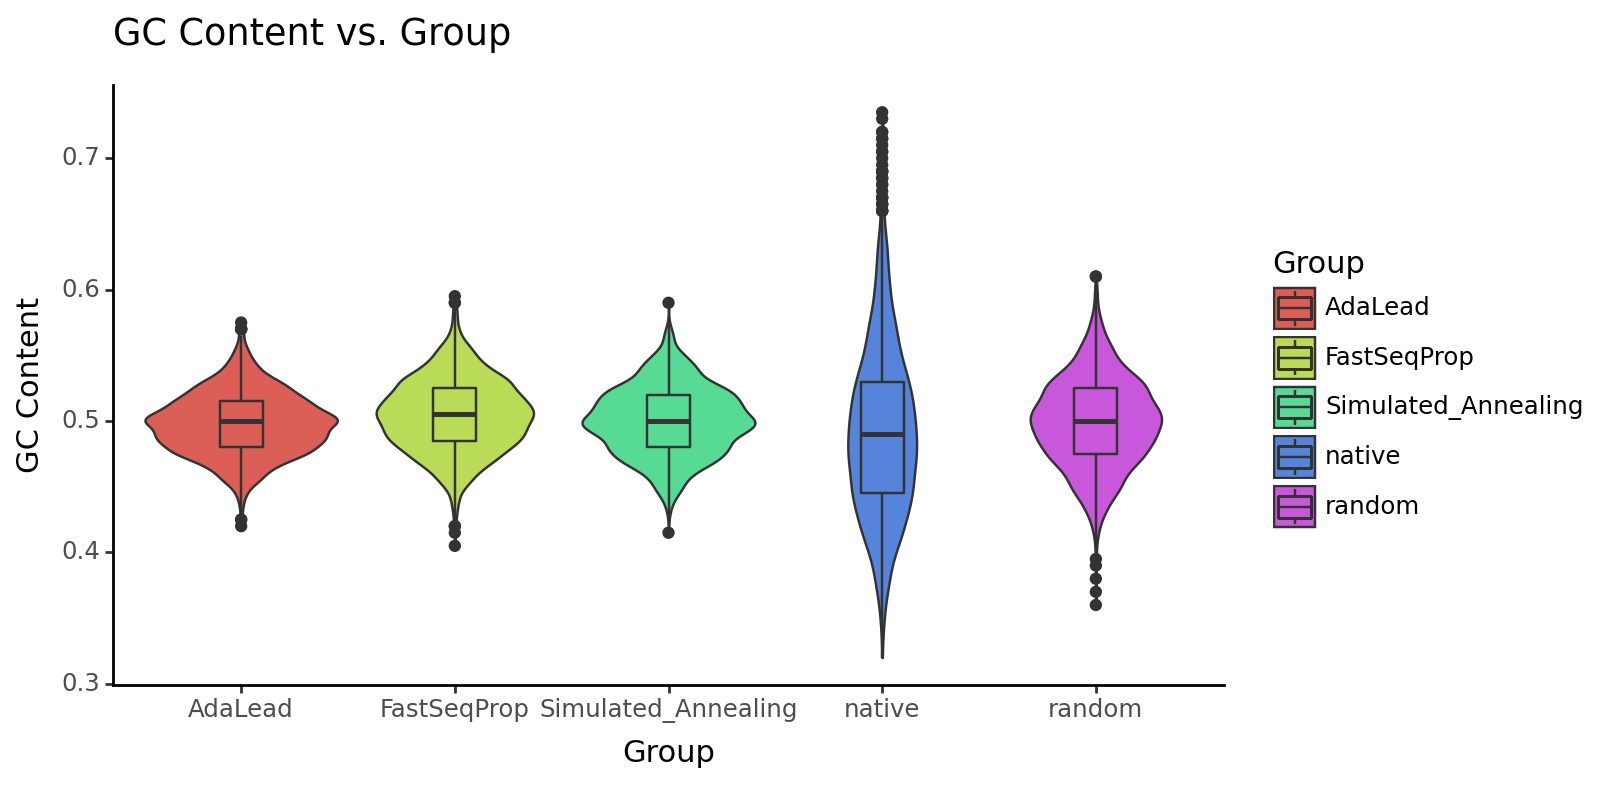

<Figure Size: (800 x 400)>

In [4]:
seqs['GC Content'] = polygraph.sequence.gc(seqs)
polygraph.visualize.boxplot(seqs, value_col='GC Content') + p9.theme(figure_size=(8, 4))

In [5]:
polygraph.stats.kruskal_dunn(data=seqs, val_col="GC Content")

{'Kruskal': 3.3631365849739994e-30,
 'Dunn':                           AdaLead   FastSeqProp  Simulated_Annealing  \
 AdaLead              1.000000e+00  1.339813e-10         8.475353e-02   
 FastSeqProp          1.339813e-10  1.000000e+00         3.600121e-04   
 Simulated_Annealing  8.475353e-02  3.600121e-04         1.000000e+00   
 native               7.994550e-06  1.277959e-30         3.789485e-13   
 random               1.000000e+00  1.057243e-06         1.000000e+00   
 
                            native        random  
 AdaLead              7.994550e-06  1.000000e+00  
 FastSeqProp          1.277959e-30  1.057243e-06  
 Simulated_Annealing  3.789485e-13  1.000000e+00  
 native               1.000000e+00  1.734562e-09  
 random               1.734562e-09  1.000000e+00  }

## 1.2 Length distribution

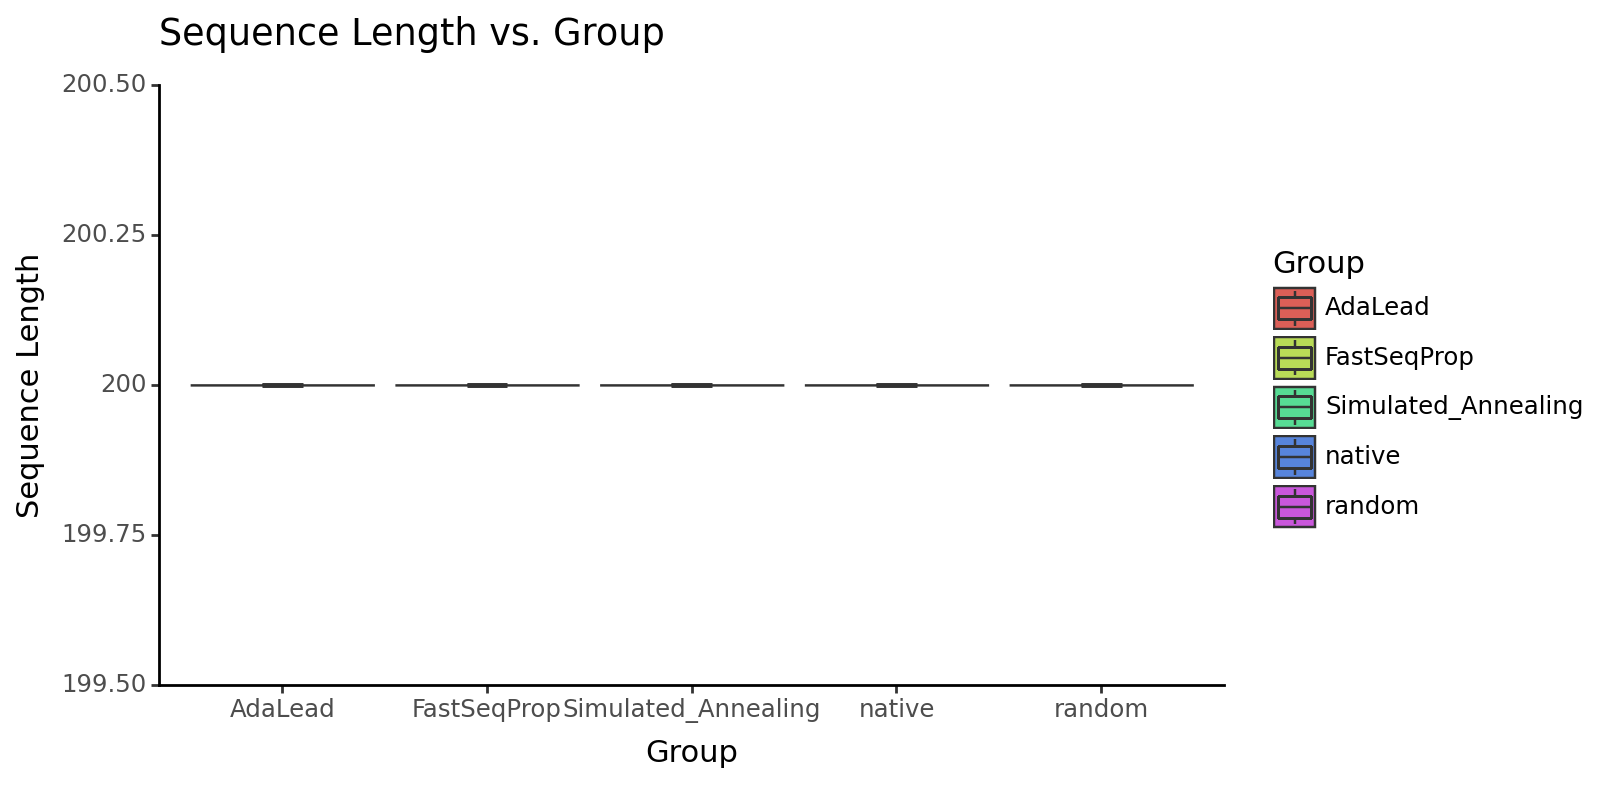

<Figure Size: (800 x 400)>

In [6]:
seqs['Sequence Length'] = seqs.Sequence.apply(len)
polygraph.visualize.boxplot(seqs, value_col='Sequence Length') + p9.theme(figure_size=(8, 4))

## 1.3 k-mer content

In [7]:
%%time
kmers = polygraph.sequence.kmer_frequencies(seqs.Sequence.tolist(), k=5, normalize=True)

CPU times: user 17.6 s, sys: 548 ms, total: 18.1 s
Wall time: 17.8 s


In [8]:
%%time
emb = polygraph.embedding.embedding_analysis(kmers, seqs, reference_group='native', use_pca=True)

Creating AnnData object
PCA


/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


Fraction of variance explained:  [0.03 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
Fraction of total variance explained:  0.24987976011050114
UMAP
Differential feature abundance
1-NN statistics


/opt/conda/lib/python3.8/site-packages/polygraph/stats.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Within-group KNN diversity
Euclidean distance to nearest reference
CPU times: user 2min 56s, sys: 24.7 s, total: 3min 20s
Wall time: 43.5 s


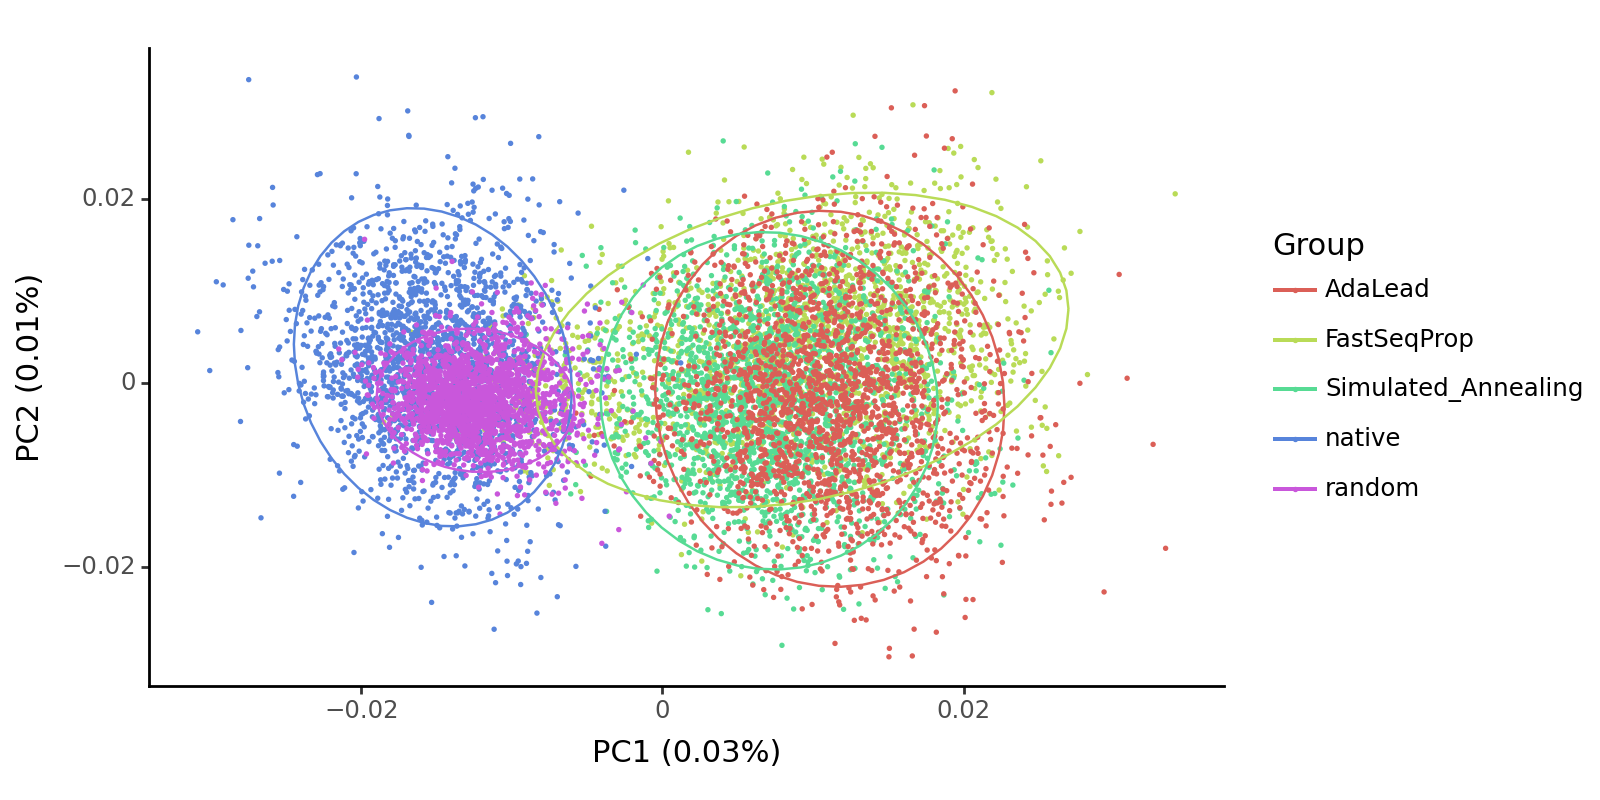

<Figure Size: (800 x 400)>

In [9]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(8, 4))

In [10]:
# Differential k-mer abundance

print("Number of differential k-mers compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential k-mers")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head(10))

Number of differential k-mers compared to reference
Group
random                 765
FastSeqProp            722
Simulated_Annealing    717
AdaLead                713
Name: count, dtype: int64

Top Differential k-mers
                    Group  value      score           padj
1024          FastSeqProp  GATAA  38.483311   0.000000e+00
0                 AdaLead  TTATC  36.801987  1.757215e-293
1025          FastSeqProp  TTATC  34.037605  3.170041e-251
2048  Simulated_Annealing  TTATC  33.948215  1.327107e-249
1                 AdaLead  GATAA  33.635479  2.603204e-245
1026          FastSeqProp  ATAAG  33.599346  5.853254e-245
2                 AdaLead  CTTAT  32.068928  4.082288e-223
3                 AdaLead  TGTCA  31.905781  5.683173e-221
1027          FastSeqProp  CTTAT  31.818279  9.259396e-220
4                 AdaLead  TGACA  30.834171  1.870147e-206


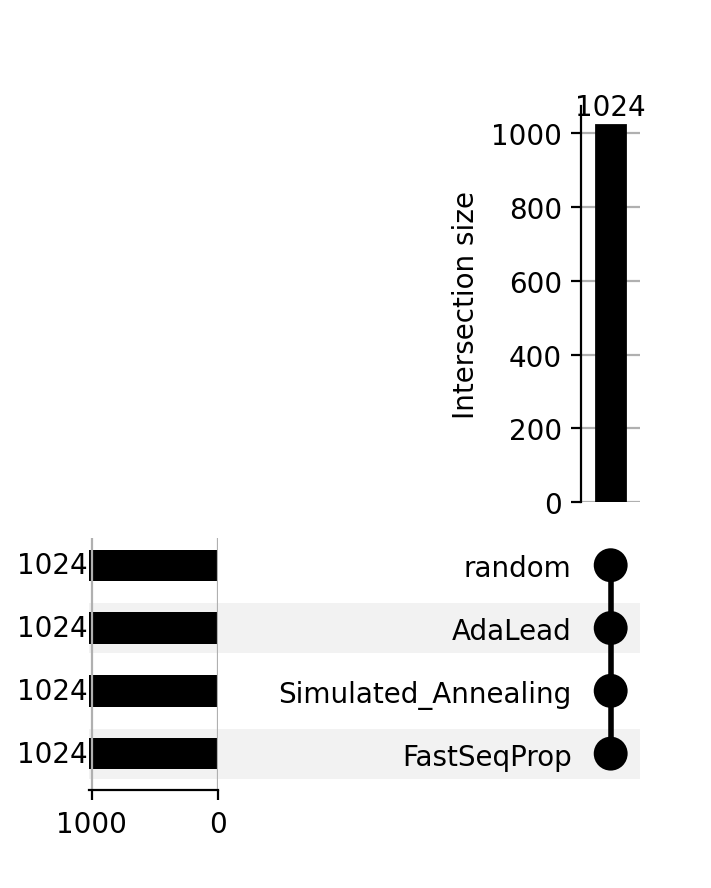

In [11]:
# kmer occurrence
polygraph.visualize.upset_plot(emb[emb.obs.Group!='native'])

In [12]:
# 1-NN statistics
print("Fraction of sequences by 1-NN group")
print(emb.uns["1NN_group_probs"])

print("")

print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

Fraction of sequences by 1-NN group
one_nn_group         AdaLead  FastSeqProp  Simulated_Annealing  native  random
Group                                                                         
AdaLead                 0.43         0.16                 0.40    0.00    0.00
FastSeqProp             0.06         0.69                 0.14    0.00    0.10
Simulated_Annealing     0.25         0.24                 0.46    0.00    0.05
native                  0.00         0.01                 0.00    0.88    0.11
random                  0.00         0.03                 0.00    0.01    0.96

p-values for proportion of sequences with native nearest neighbor
                     group_prop  ref_prop  pval  padj
Group                                                
FastSeqProp              0.0045     0.879   0.0   0.0
Simulated_Annealing      0.0035     0.879   0.0   0.0
AdaLead                  0.0010     0.879   0.0   0.0
random                   0.0120     0.879   0.0   0.0


p-values for distance to closest reference
{'Kruskal': 0.0, 'Dunn':                           AdaLead   FastSeqProp  Simulated_Annealing  native  \
AdaLead              1.000000e+00  7.519483e-34         1.230345e-41     0.0   
FastSeqProp          7.519483e-34  1.000000e+00         1.000000e+00     0.0   
Simulated_Annealing  1.230345e-41  1.000000e+00         1.000000e+00     0.0   
native               0.000000e+00  0.000000e+00         0.000000e+00     1.0   
random               0.000000e+00  0.000000e+00         0.000000e+00     1.0   

                     random  
AdaLead                 0.0  
FastSeqProp             0.0  
Simulated_Annealing     0.0  
native                  1.0  
random                  1.0  }


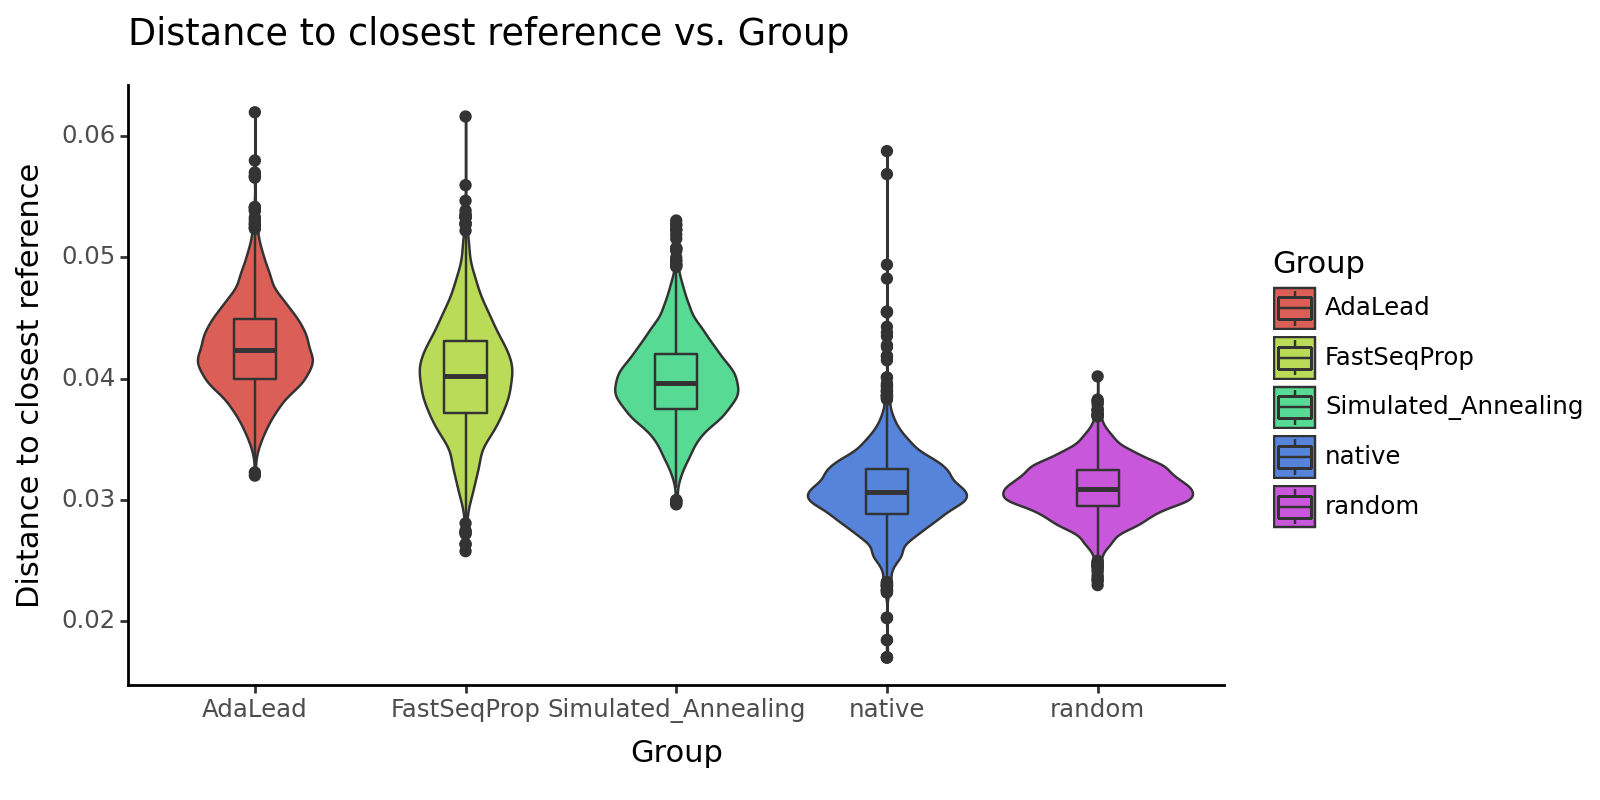

<Figure Size: (800 x 400)>

In [13]:
#Distance to reference
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(8, 4))

p-values for KNN diversity
{'Kruskal': 0.0, 'Dunn':                            AdaLead    FastSeqProp  Simulated_Annealing  \
AdaLead               1.000000e+00  9.384288e-186         1.890244e-46   
FastSeqProp          9.384288e-186   1.000000e+00         9.106645e-48   
Simulated_Annealing   1.890244e-46   9.106645e-48         1.000000e+00   
native               3.060118e-216   2.066646e-01         9.638958e-64   
random                0.000000e+00   0.000000e+00         0.000000e+00   

                            native  random  
AdaLead              3.060118e-216     0.0  
FastSeqProp           2.066646e-01     0.0  
Simulated_Annealing   9.638958e-64     0.0  
native                1.000000e+00     0.0  
random                0.000000e+00     1.0  }


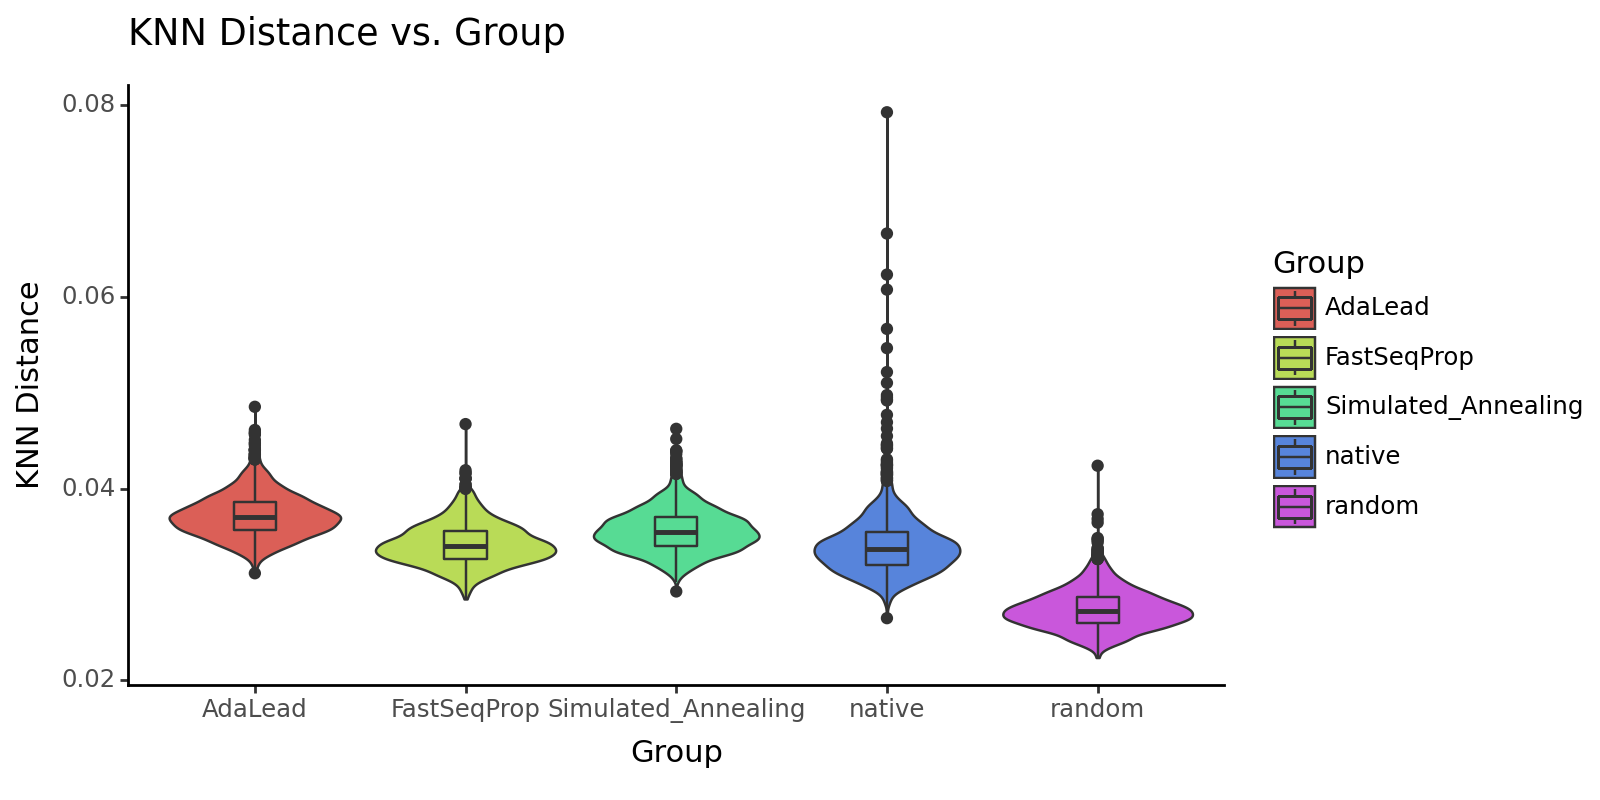

<Figure Size: (800 x 400)>

In [14]:
# KNN distance (diversity metric)
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(8, 4))

## 2. Motif content

In [15]:
jaspar = polygraph.input.load_jaspar()

In [16]:
len(jaspar)

841

In [17]:
%%time 
counts = polygraph.motifs.motif_frequencies(seqs, jaspar, num_workers=8, normalize=True)

Processing motifs
Scanning
Assembling count matrix
CPU times: user 7.85 s, sys: 7.82 s, total: 15.7 s
Wall time: 46min 55s


In [18]:
meta = pd.DataFrame(counts.columns, columns=['MotifID'])
counts = counts.loc[:, ~counts.columns.isna()]

In [19]:
counts.to_csv('human_counts.csv', index=False)

In [20]:
%%time
emb = polygraph.embedding.embedding_analysis(counts, seqs, reference_group='native')

Creating AnnData object
PCA


/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Fraction of variance explained:  [0.1  0.04 0.03 0.03 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
Fraction of total variance explained:  0.5027653527851327
UMAP
Differential feature abundance
1-NN statistics


/opt/conda/lib/python3.8/site-packages/polygraph/stats.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Within-group KNN diversity
Euclidean distance to nearest reference
CPU times: user 4min 14s, sys: 26 s, total: 4min 40s
Wall time: 2min 8s


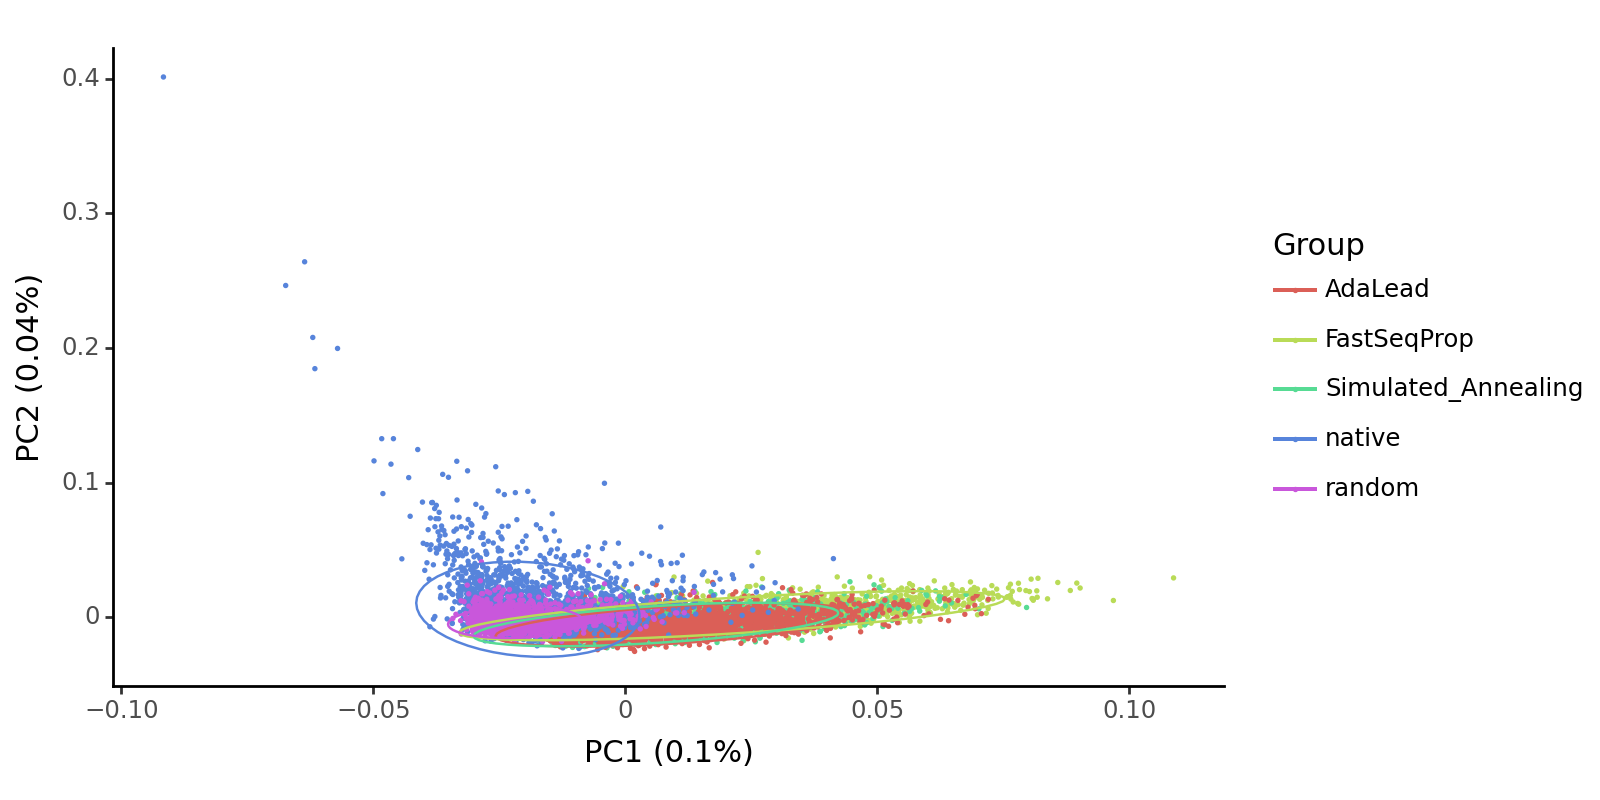

<Figure Size: (800 x 400)>

In [21]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(8, 4))

In [22]:
# Differential motif abundance

print("Number of differential motifs compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential motifs")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head(10))

Number of differential motifs compared to reference
Group
AdaLead                624
Simulated_Annealing    576
FastSeqProp            551
random                 549
Name: count, dtype: int64

Top Differential motifs
           Group    value      score           padj
841  FastSeqProp    GATA5  37.837093   0.000000e+00
842  FastSeqProp    Tcf21  35.851997  7.198251e-279
843  FastSeqProp    Tcf12  35.155411  2.693936e-268
844  FastSeqProp    Ptf1A  34.566570  1.689419e-259
845  FastSeqProp     MYF5  34.427288  1.656832e-257
846  FastSeqProp  TGIF2LX  34.414242  2.164267e-257
0        AdaLead    GATA2  34.244320  4.456548e-254
1        AdaLead    GATA5  34.096439  3.502592e-252
847  FastSeqProp  Bhlha15  34.049873  4.897363e-252
848  FastSeqProp    Ptf1A  33.705631  5.025466e-247


In [23]:
# 1-NN statistics
print("Fraction of sequences by 1-NN group")
print(emb.uns["1NN_group_probs"])

print("")

print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

Fraction of sequences by 1-NN group
one_nn_group         AdaLead  FastSeqProp  Simulated_Annealing  native  random
Group                                                                         
AdaLead                 0.41         0.22                 0.35    0.00    0.02
FastSeqProp             0.17         0.55                 0.20    0.01    0.07
Simulated_Annealing     0.34         0.27                 0.34    0.01    0.04
native                  0.04         0.07                 0.06    0.40    0.43
random                  0.02         0.05                 0.02    0.03    0.89

p-values for proportion of sequences with native nearest neighbor
                     group_prop  ref_prop           pval           padj
Group                                                                  
FastSeqProp              0.0070    0.4015  1.970596e-259  2.627462e-259
Simulated_Annealing      0.0055    0.4015  3.249897e-264  6.499795e-264
AdaLead                  0.0025    0.4015  6.340163e-275

p-values for distance to closest reference
{'Kruskal': 2.0093885180940032e-256, 'Dunn':                            AdaLead    FastSeqProp  Simulated_Annealing  \
AdaLead               1.000000e+00   2.002259e-01         6.920116e-11   
FastSeqProp           2.002259e-01   1.000000e+00         5.804976e-05   
Simulated_Annealing   6.920116e-11   5.804976e-05         1.000000e+00   
native                1.000000e+00   1.000000e+00         6.531620e-09   
random               6.588088e-185  1.132461e-156        2.207670e-108   

                            native         random  
AdaLead               1.000000e+00  6.588088e-185  
FastSeqProp           1.000000e+00  1.132461e-156  
Simulated_Annealing   6.531620e-09  2.207670e-108  
native                1.000000e+00  2.208825e-176  
random               2.208825e-176   1.000000e+00  }


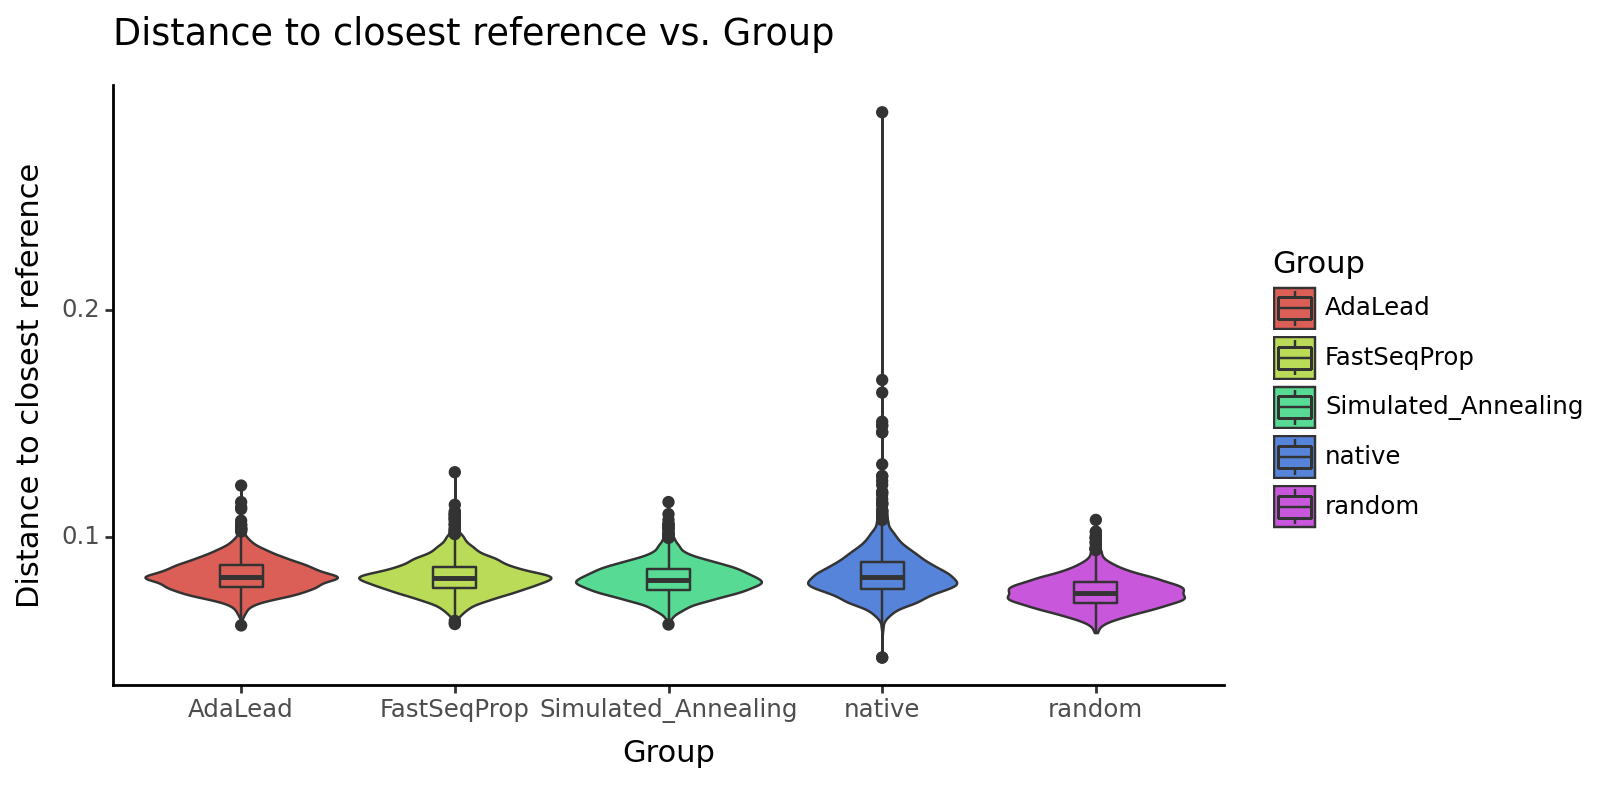

<Figure Size: (800 x 400)>

In [25]:
#Distance to reference
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(8, 4))

p-values for KNN diversity
{'Kruskal': 0.0, 'Dunn':                            AdaLead    FastSeqProp  Simulated_Annealing  \
AdaLead               1.000000e+00   5.555830e-15         1.510829e-02   
FastSeqProp           5.555830e-15   1.000000e+00         8.389334e-06   
Simulated_Annealing   1.510829e-02   8.389334e-06         1.000000e+00   
native               2.166443e-137  7.871352e-240        3.938829e-174   
random                2.609473e-99   1.446298e-38         3.934992e-72   

                            native        random  
AdaLead              2.166443e-137  2.609473e-99  
FastSeqProp          7.871352e-240  1.446298e-38  
Simulated_Annealing  3.938829e-174  3.934992e-72  
native                1.000000e+00  0.000000e+00  
random                0.000000e+00  1.000000e+00  }


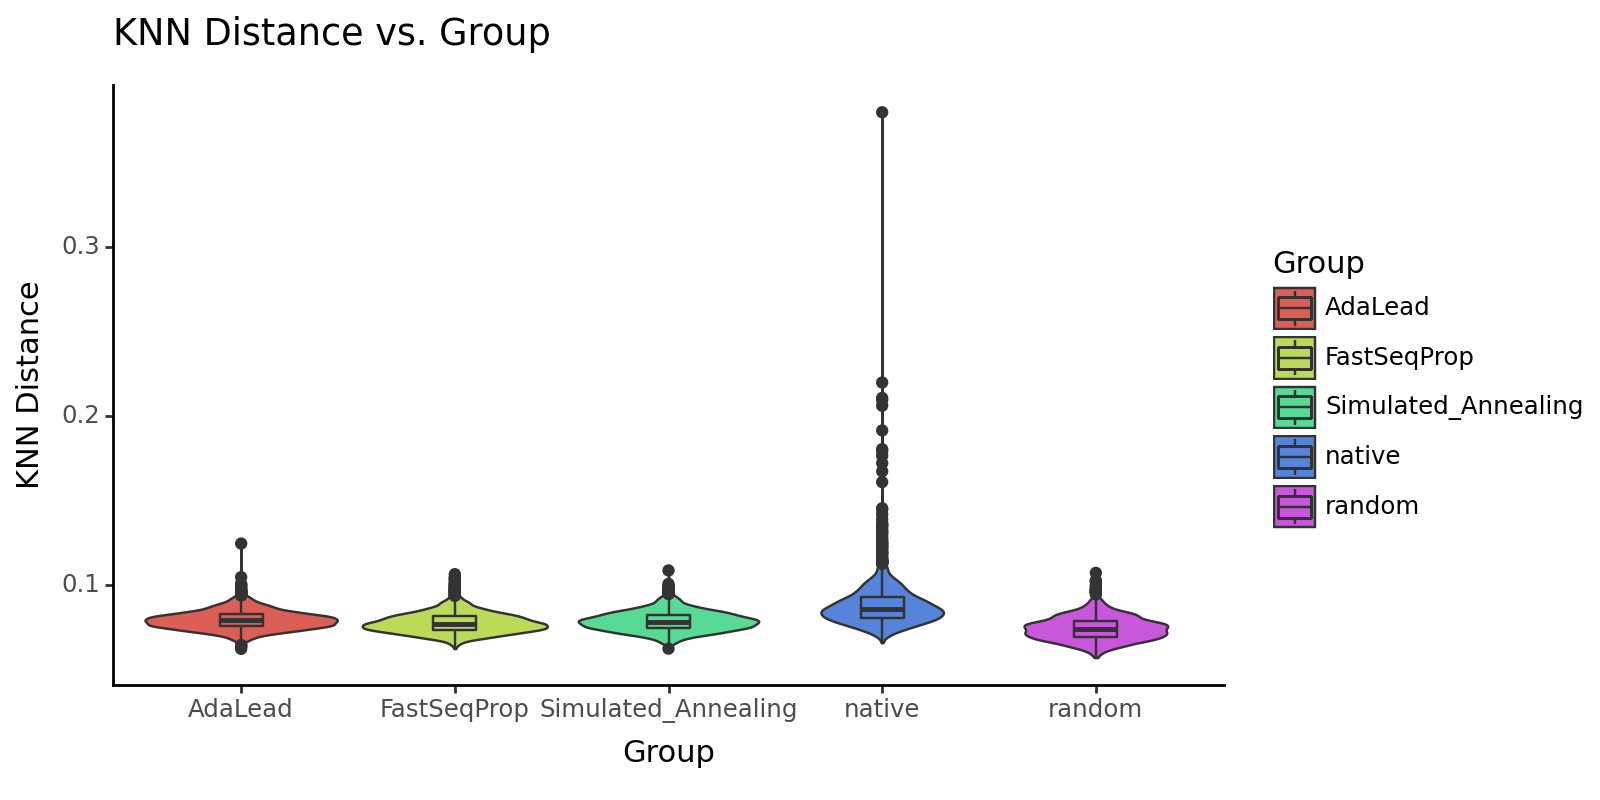

<Figure Size: (800 x 400)>

In [26]:
# KNN distance (diversity metric)
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(8, 4))

## 2.2 Motif combinations

In [27]:
%%time
motif_combinations = polygraph.motifs.motif_combinations(counts.iloc[:50, :50], seqs, reference_group='native')

Listing motif combinations
Making count matrix
Filtering
Selected 7 combinations
Significance testing
CPU times: user 91.5 ms, sys: 3.9 ms, total: 95.4 ms
Wall time: 94.5 ms


In [28]:
len(set(motif_combinations.combination))

7

In [29]:
motif_combinations.sort_values('padj').head(10)

,Group,group_prop,ref_prop,pval,padj,combination
0,FastSeqProp,0.0100,0.0,0.000002,0.000051,"(TAL1::TCF3, Mecom)"
4,FastSeqProp,0.0070,0.0,0.000119,0.001670,"(TAL1::TCF3, REST)"
24,FastSeqProp,0.0055,0.0,0.000963,0.003853,"(TAL1::TCF3, DUX4)"
20,FastSeqProp,0.0055,0.0,0.000963,0.003853,"(TAL1::TCF3, MAX::MYC)"
8,FastSeqProp,0.0060,0.0,0.000480,0.003853,"(TAL1::TCF3, CTCF)"
12,FastSeqProp,0.0055,0.0,0.000963,0.003853,"(TAL1::TCF3, Hand1::Tcf3)"
16,FastSeqProp,0.0055,0.0,0.000963,0.003853,"(TAL1::TCF3, RARA::RXRA)"
25,Simulated_Annealing,0.0000,0.0,1.000000,1.000000,"(TAL1::TCF3, DUX4)"
23,random,0.0000,0.0,1.000000,1.000000,"(TAL1::TCF3, MAX::MYC)"
22,AdaLead,0.0000,0.0,1.000000,1.000000,"(TAL1::TCF3, MAX::MYC)"


In [30]:
# Are there any significant motif combinations where neither individual motif is significant?
sig_motifs = emb.uns["DE_test"][emb.uns["DE_test"].padj < .01].value.tolist()
sig_combs = motif_combinations[motif_combinations['padj'] < .01]
sig_combs = sig_combs[sig_combs.combination.apply(lambda c: (c[0] not in sig_motifs) and (c[1] not in sig_motifs))]

In [31]:
sig_combs[sig_combs.Group=='FastSeqProp']

,Group,group_prop,ref_prop,pval,padj,combination


## 2.3 Motif positions

In [32]:
# Select the TF motif most enriched in synthetic sequences
emb.uns['DE_test'].sort_values('padj').head()

,Group,value,score,padj
841,FastSeqProp,GATA5,37.837093,0.000000e+00
842,FastSeqProp,Tcf21,35.851997,7.198251e-279
843,FastSeqProp,Tcf12,35.155411,2.693936e-268
844,FastSeqProp,Ptf1A,34.566570,1.689419e-259
845,FastSeqProp,MYF5,34.427288,1.656832e-257


In [33]:
%%time
sites = polygraph.motifs.scan_seqs(seqs, [m for m in jaspar if m.name=="GATA5"], num_workers=8)
sites.head()

Processing motifs
Scanning
CPU times: user 4.56 s, sys: 4.02 s, total: 8.58 s
Wall time: 12.5 s


,MotifID,score,start,end,SeqID,Group
0,GATA5,12.862686,73.0,83.0,0,FastSeqProp
1,GATA5,9.943519,162.0,172.0,1,FastSeqProp
2,GATA5,10.704187,188.0,198.0,1,FastSeqProp
3,GATA5,13.219183,178.0,188.0,3,FastSeqProp
4,GATA5,11.608216,189.0,199.0,4,FastSeqProp


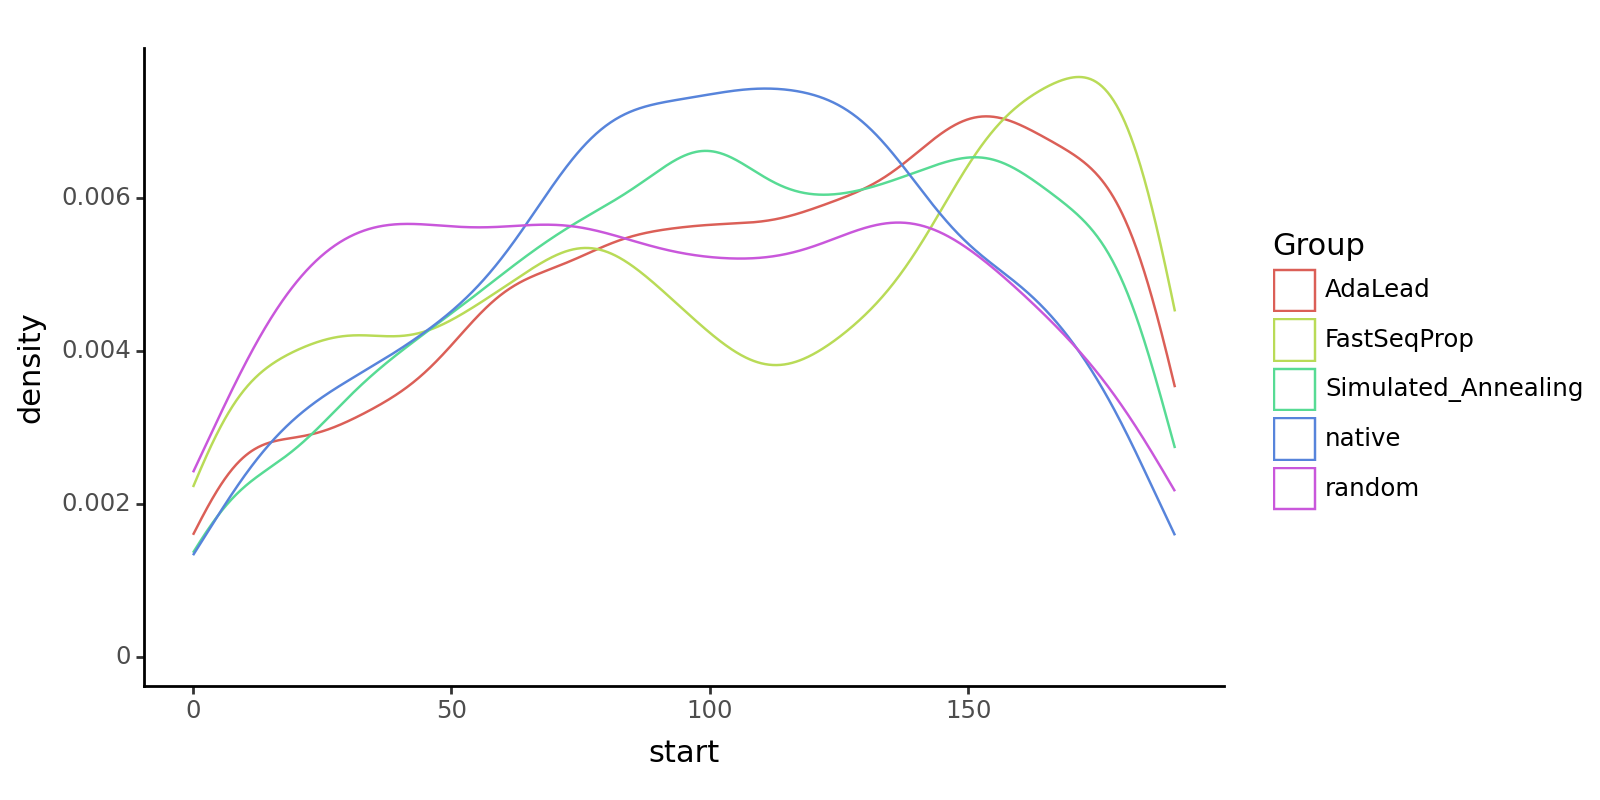

<Figure Size: (800 x 400)>

In [34]:
polygraph.visualize.densityplot(sites, value_col='start') + p9.theme(figure_size=(8, 4))

In [35]:
polygraph.stats.kruskal_dunn(sites, val_col='start')

{'Kruskal': 9.97818676002684e-12,
 'Dunn':                           AdaLead  FastSeqProp  Simulated_Annealing  \
 AdaLead              1.000000e+00     1.000000             0.070008   
 FastSeqProp          1.000000e+00     1.000000             1.000000   
 Simulated_Annealing  7.000767e-02     1.000000             1.000000   
 native               7.333414e-07     0.000061             0.006916   
 random               5.439390e-08     0.000002             0.000079   
 
                            native        random  
 AdaLead              7.333414e-07  5.439390e-08  
 FastSeqProp          6.120545e-05  1.651604e-06  
 Simulated_Annealing  6.916208e-03  7.908848e-05  
 native               1.000000e+00  5.729481e-01  
 random               5.729481e-01  1.000000e+00  }

## 2.4 NMF

In [36]:
%%time
W, H, p = polygraph.motifs.nmf(counts, seqs, reference_group='native', n_components=10)

CPU times: user 1min 45s, sys: 3.96 s, total: 1min 49s
Wall time: 978 ms


In [37]:
p[p.padj < .001]

,group,pval,padj,factor
0,FastSeqProp,0.000000e+00,0.000000e+00,factor_0
1,Simulated_Annealing,2.070564e-108,4.141128e-108,factor_0
2,AdaLead,4.440308e-138,1.044778e-137,factor_0
3,random,1.175549e-37,1.621447e-37,factor_0
0,FastSeqProp,1.949513e-141,4.873783e-141,factor_1
1,Simulated_Annealing,1.544145e-32,1.930181e-32,factor_1
2,AdaLead,2.375630e-12,2.715006e-12,factor_1
3,random,1.661587e-40,2.556287e-40,factor_1
0,FastSeqProp,7.983365e-102,1.520641e-101,factor_2
1,Simulated_Annealing,5.071108e-131,1.126913e-130,factor_2


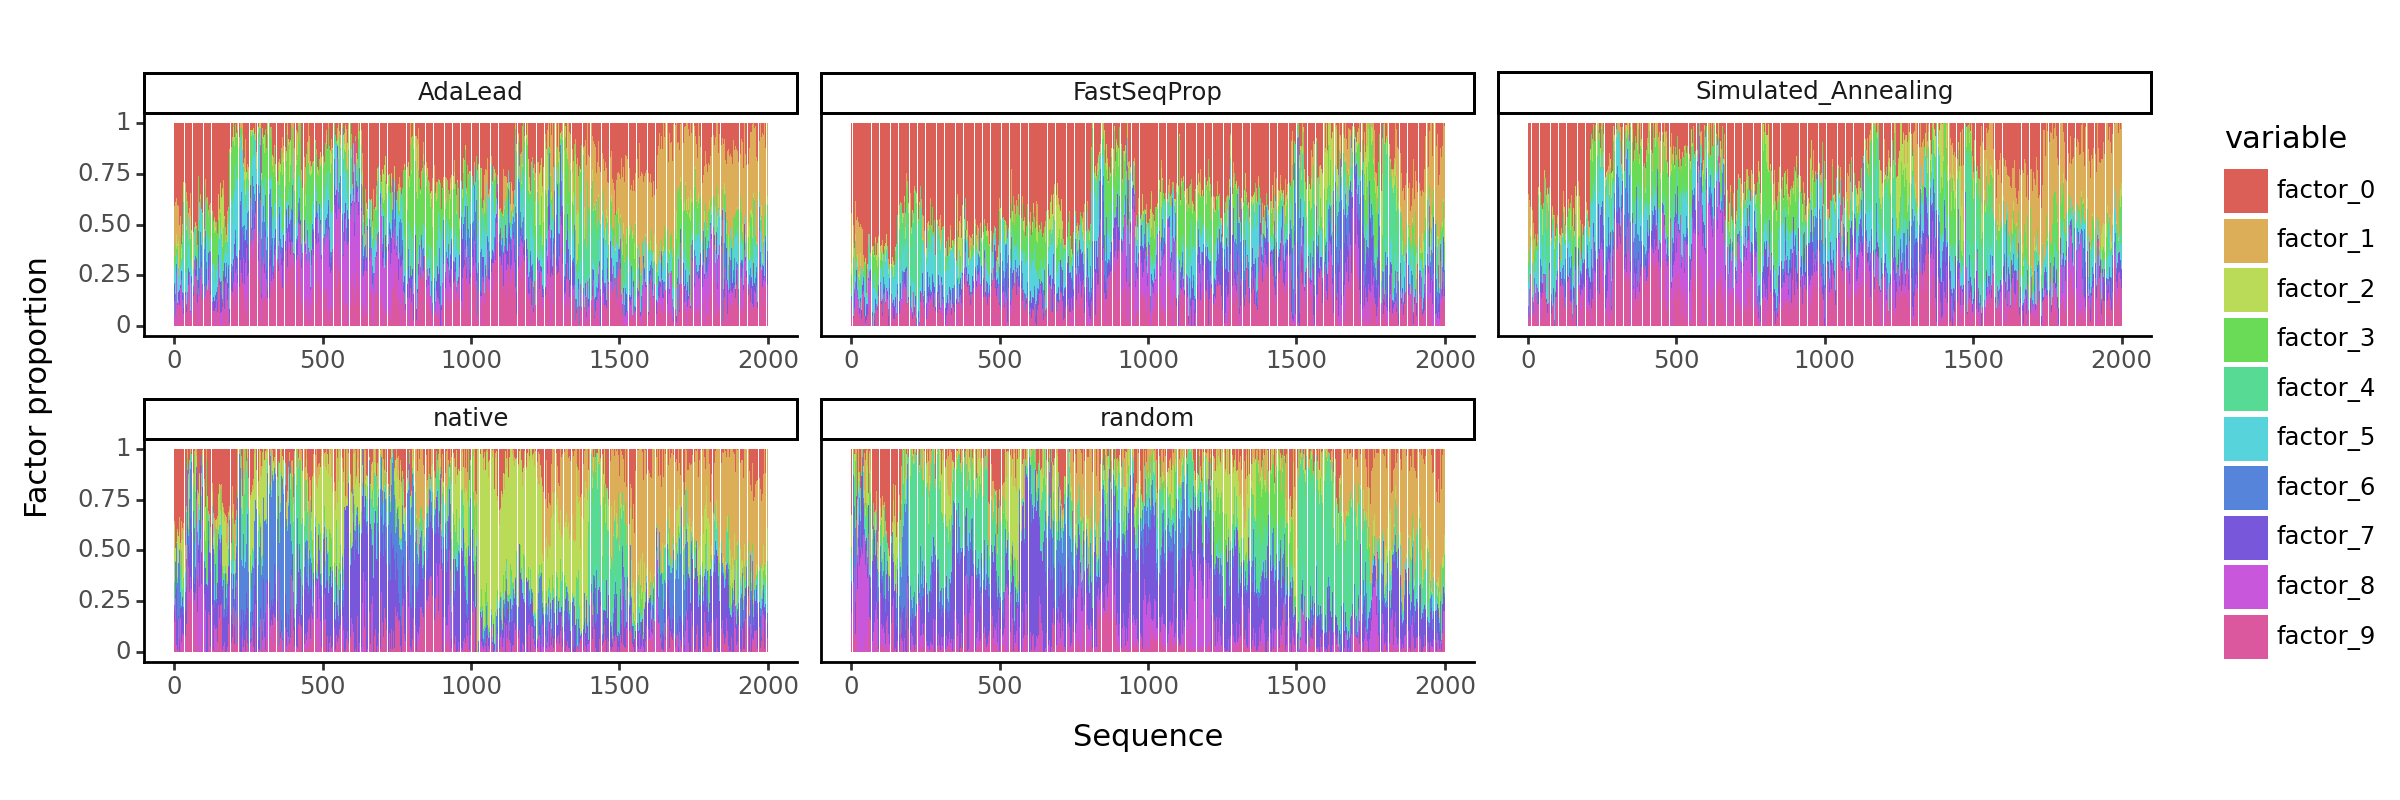

<Figure Size: (1200 x 400)>

In [38]:
polygraph.visualize.plot_seqs_nmf(W) + p9.theme(figure_size=(12, 4))

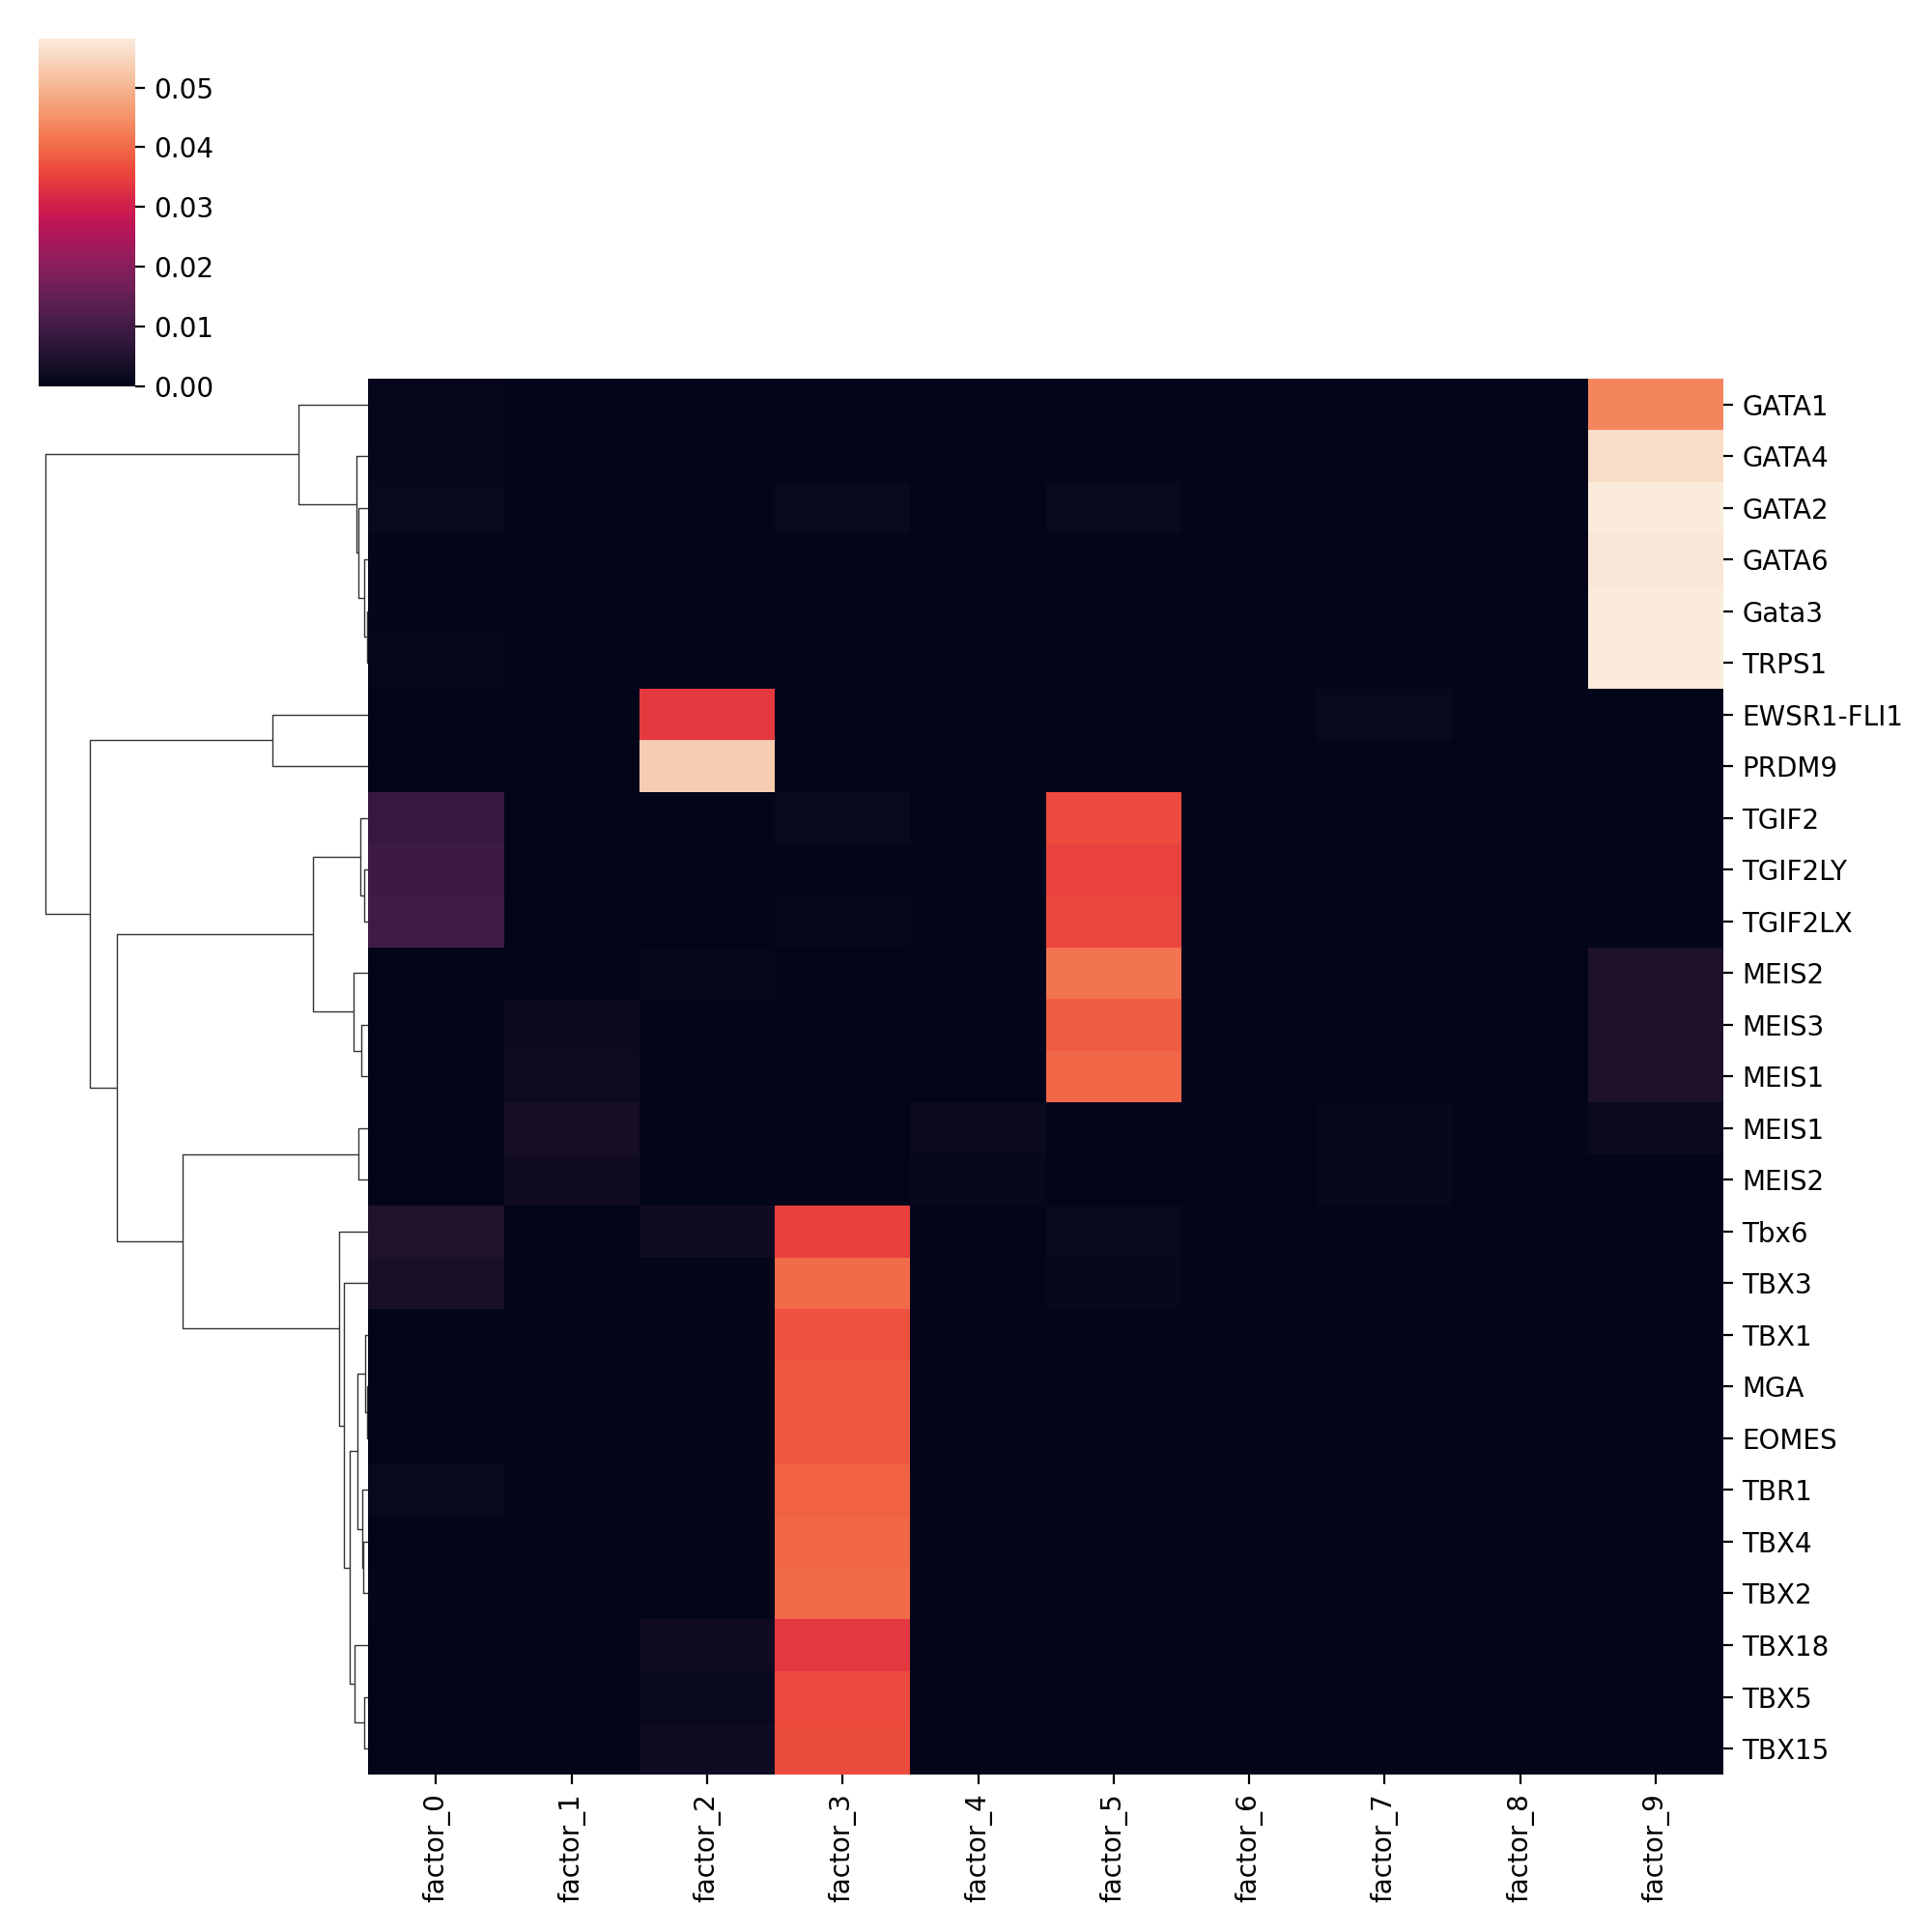

In [39]:
polygraph.visualize.plot_factors_nmf(H, n_features=25)

# 3. Model predictions

### Load model trained on catlas data

In [40]:
!wget https://zenodo.org/records/8412250/files/catlas-enformer-release-model.pth

--2023-11-28 06:11:10--  https://zenodo.org/records/8412250/files/catlas-enformer-release-model.pth
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 288429703 (275M) [application/octet-stream]
Saving to: ‘catlas-enformer-release-model.pth’

catlas-enformer-rel 100%[===================>] 275.07M  19.1MB/s    in 16s     

2023-11-28 06:11:28 (16.7 MB/s) - ‘catlas-enformer-release-model.pth’ saved [288429703/288429703]



In [49]:
import torch
#model = torch.load('/data/eraslag1/catlas-enformer-release-model_2.pth')
model = torch.load('catlas-enformer-release-model.pth')

### Get model predictions

In [51]:
preds = polygraph.models.predict(model, seqs, batch_size=512)
preds.shape

Padding all sequences to length 200


(10000, 203)

### Model embeddings

In [52]:
embeddings = polygraph.models.sequential_embed(seqs.Sequence.tolist(), model, drop_last_layers=4, swapaxes=True)
embeddings.shape

(10000, 1536)

In [53]:
%%time
emb = polygraph.embedding.embedding_analysis(embeddings, seqs, reference_group='native')

Creating AnnData object
PCA


/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


Fraction of variance explained:  [0.74 0.07 0.03 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
Fraction of total variance explained:  0.9680153
UMAP
Differential feature abundance


/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value 

1-NN statistics


/opt/conda/lib/python3.8/site-packages/polygraph/stats.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Within-group KNN diversity
Euclidean distance to nearest reference
CPU times: user 3min 16s, sys: 21 s, total: 3min 37s
Wall time: 47.7 s


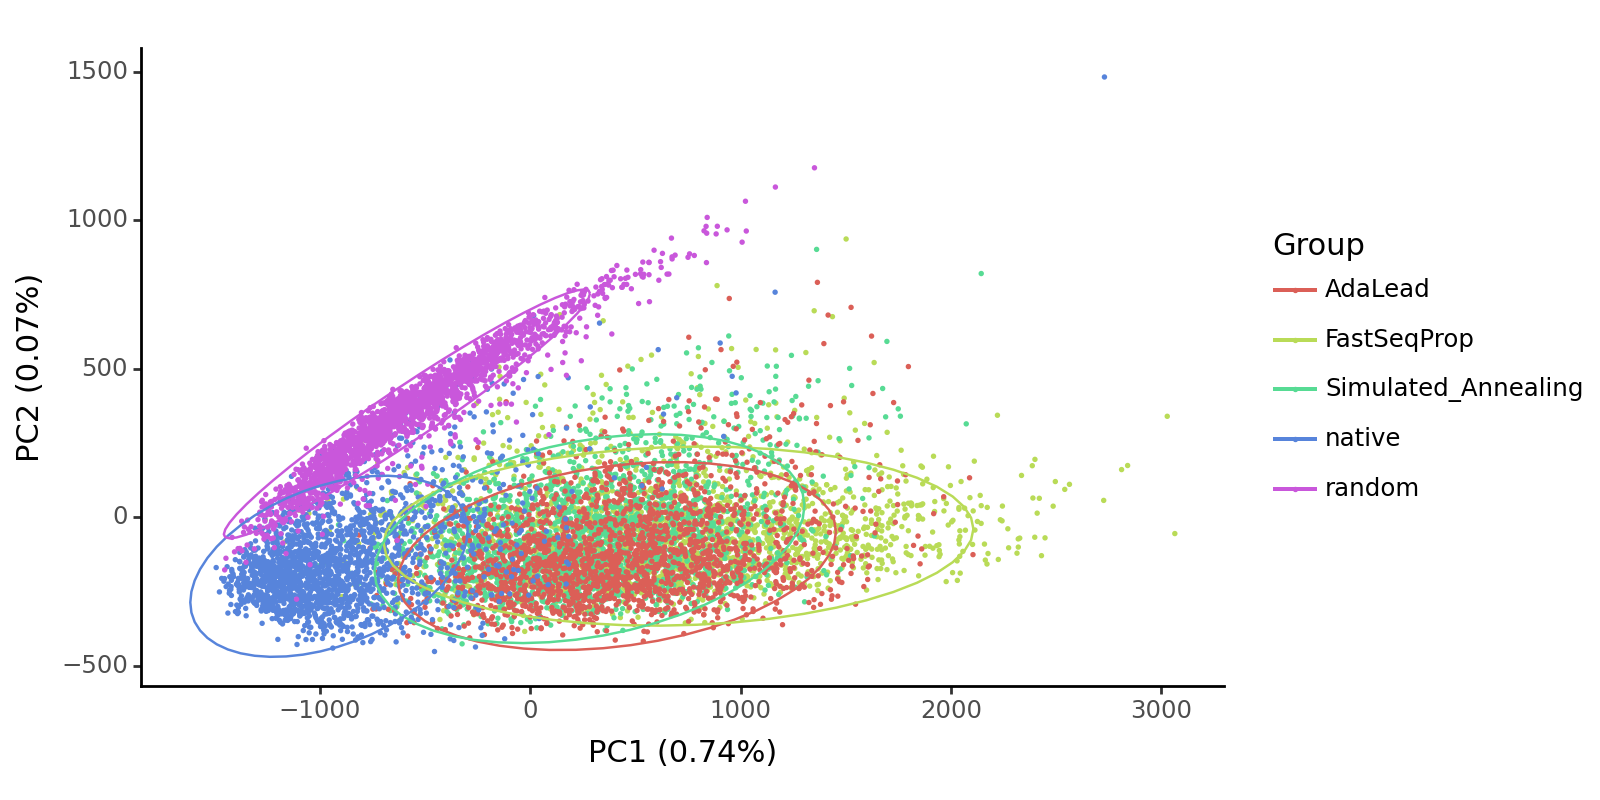

<Figure Size: (800 x 400)>

In [54]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(8, 4))

In [55]:
# 1-NN statistics
print(emb.uns["1NN_group_probs"])
print(emb.uns["1NN_ref_prop_test"])

one_nn_group         AdaLead  FastSeqProp  Simulated_Annealing  native  random
Group                                                                         
AdaLead                 0.57         0.10                 0.32    0.00    0.00
FastSeqProp             0.12         0.65                 0.22    0.00    0.01
Simulated_Annealing     0.33         0.18                 0.49    0.00    0.00
native                  0.00         0.01                 0.00    0.94    0.04
random                  0.00         0.01                 0.00    0.01    0.98
                     group_prop  ref_prop  pval  padj
Group                                                
FastSeqProp              0.0010    0.9375   0.0   0.0
Simulated_Annealing      0.0010    0.9375   0.0   0.0
AdaLead                  0.0000    0.9375   0.0   0.0
random                   0.0115    0.9375   0.0   0.0


{'Kruskal': 0.0, 'Dunn':                           AdaLead   FastSeqProp  Simulated_Annealing  \
AdaLead              1.000000e+00  1.786902e-08         1.232315e-09   
FastSeqProp          1.786902e-08  1.000000e+00         1.374500e-34   
Simulated_Annealing  1.232315e-09  1.374500e-34         1.000000e+00   
native               0.000000e+00  0.000000e+00         0.000000e+00   
random               0.000000e+00  0.000000e+00        1.084725e-241   

                           native         random  
AdaLead              0.000000e+00   0.000000e+00  
FastSeqProp          0.000000e+00   0.000000e+00  
Simulated_Annealing  0.000000e+00  1.084725e-241  
native               1.000000e+00   1.172607e-55  
random               1.172607e-55   1.000000e+00  }


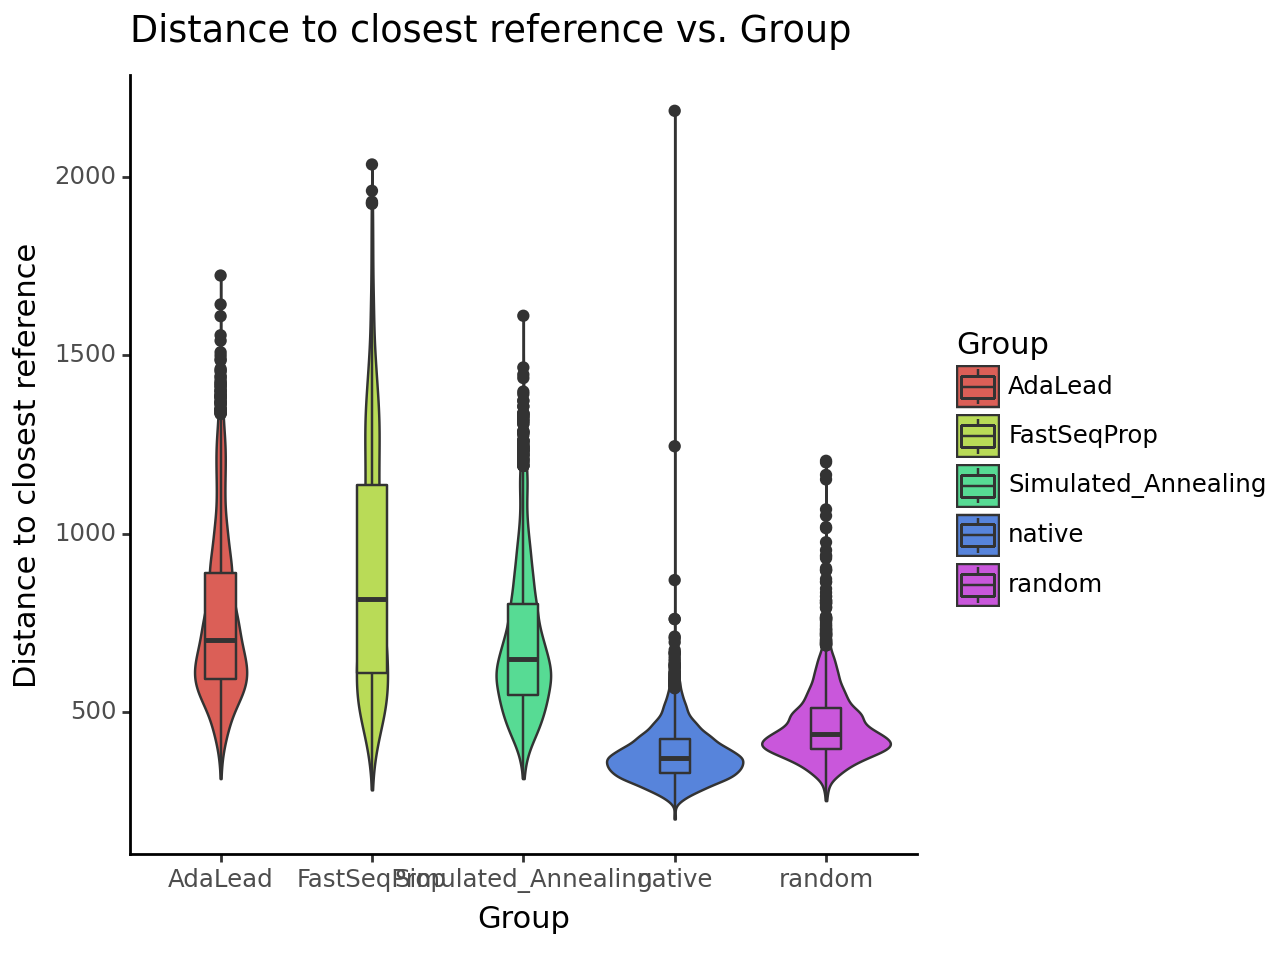

<Figure Size: (640 x 480)>

In [56]:
#Distance to reference
print(emb.uns['ref_dist_test'])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(8, 4))

{'Kruskal': 0.0, 'Dunn':                            AdaLead   FastSeqProp  Simulated_Annealing  \
AdaLead               1.000000e+00  1.756541e-11         4.555330e-01   
FastSeqProp           1.756541e-11  1.000000e+00         1.402829e-18   
Simulated_Annealing   4.555330e-01  1.402829e-18         1.000000e+00   
native                2.324677e-25  3.561196e-03         1.582926e-35   
random               1.965546e-274  0.000000e+00        1.753594e-244   

                           native         random  
AdaLead              2.324677e-25  1.965546e-274  
FastSeqProp          3.561196e-03   0.000000e+00  
Simulated_Annealing  1.582926e-35  1.753594e-244  
native               1.000000e+00   0.000000e+00  
random               0.000000e+00   1.000000e+00  }


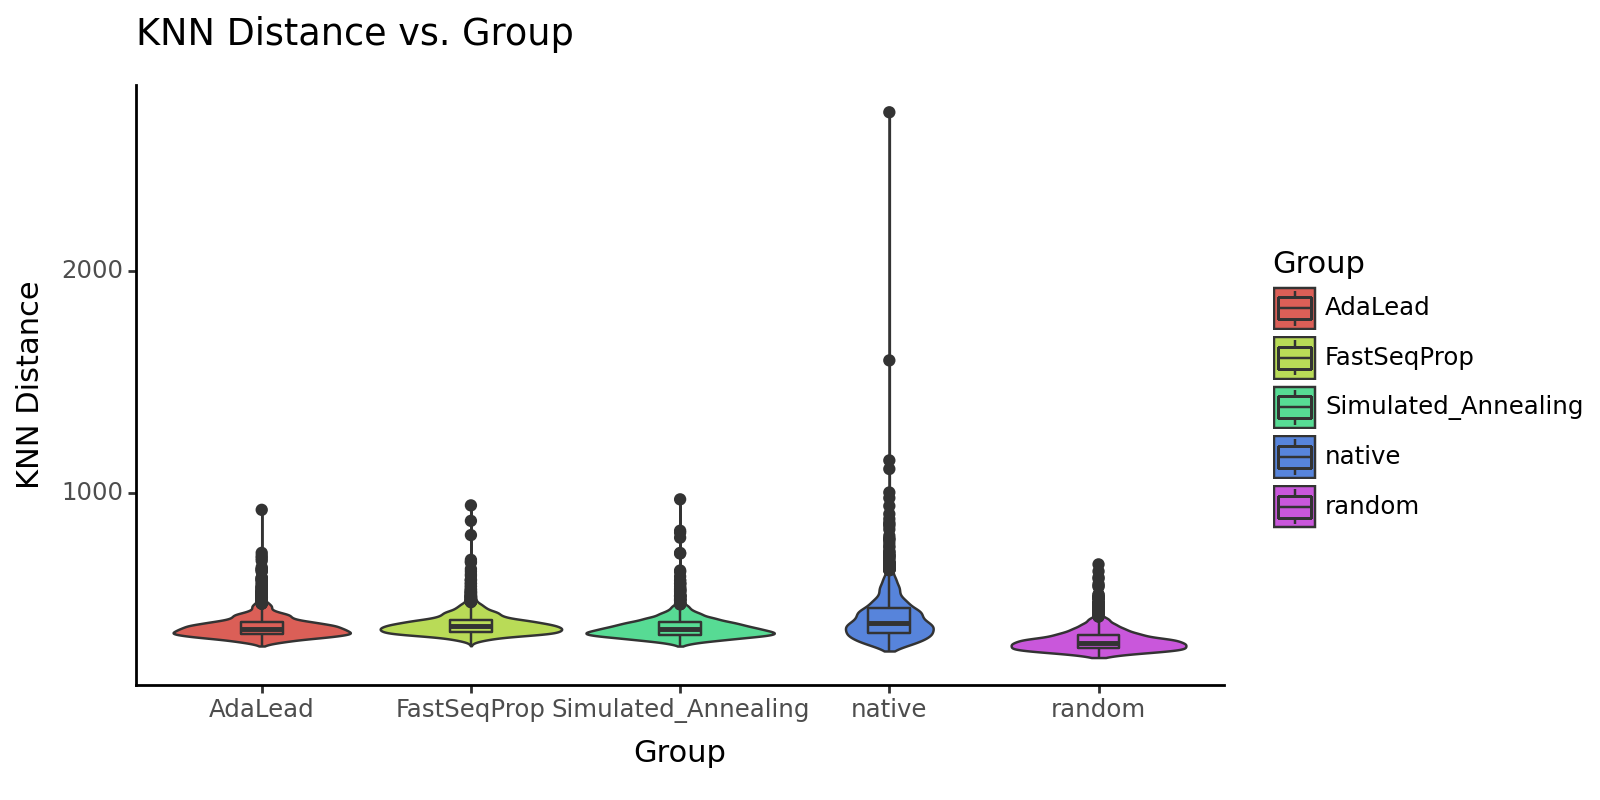

<Figure Size: (800 x 400)>

In [57]:
# KNN distance (diversity metric)
print(emb.uns['knn_dist_test'])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(8, 4))

# 4. Language model likelihood calculation

In [58]:
model = polygraph.likelihood.load_hyenadna('/hyena-dna')

--2023-11-28 06:25:44--  https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen/resolve/main/config.json
Resolving huggingface.co (huggingface.co)... 108.138.246.67, 108.138.246.79, 108.138.246.71, ...
Connecting to huggingface.co (huggingface.co)|108.138.246.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 535 [text/plain]
Saving to: ‘./config.json’

     0K                                                       100%  107M=0s

2023-11-28 06:25:49 (107 MB/s) - ‘./config.json’ saved [535/535]

--2023-11-28 06:25:49--  https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen/resolve/main/weights.ckpt
Resolving huggingface.co (huggingface.co)... 108.138.246.71, 108.138.246.67, 108.138.246.85, ...
Connecting to huggingface.co (huggingface.co)|108.138.246.71|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/23/bd/23bd011121e3699e6bfa5aa57274ac119b996f4c129b31145d6fffeaa6229b55/33558e085d0545

Loading config
Building model
Loading weights


In [59]:
seqs['Sequences'] = seqs['Sequence'] 
log_likelihood = polygraph.likelihood.compute_likelihood(seqs, model, num_workers=8, device=0)
seqs['log_likelihood'] = log_likelihood

In [60]:
seqs.groupby('Group')['log_likelihood'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
AdaLead,2000.0,-287.529963,4.207663,-300.133160,-290.471678,-287.678083,-284.788425,-271.775630
FastSeqProp,2000.0,-288.555368,3.891141,-301.424845,-291.238310,-288.652168,-286.003652,-271.726299
Simulated_Annealing,2000.0,-288.718823,4.020703,-303.138265,-291.429986,-288.839250,-286.143655,-272.198025
native,2000.0,-258.771452,24.348508,-287.612707,-269.518473,-265.318044,-259.439128,-88.924113
random,2000.0,-288.955507,4.006539,-300.572636,-291.700886,-289.038132,-286.458120,-268.709954


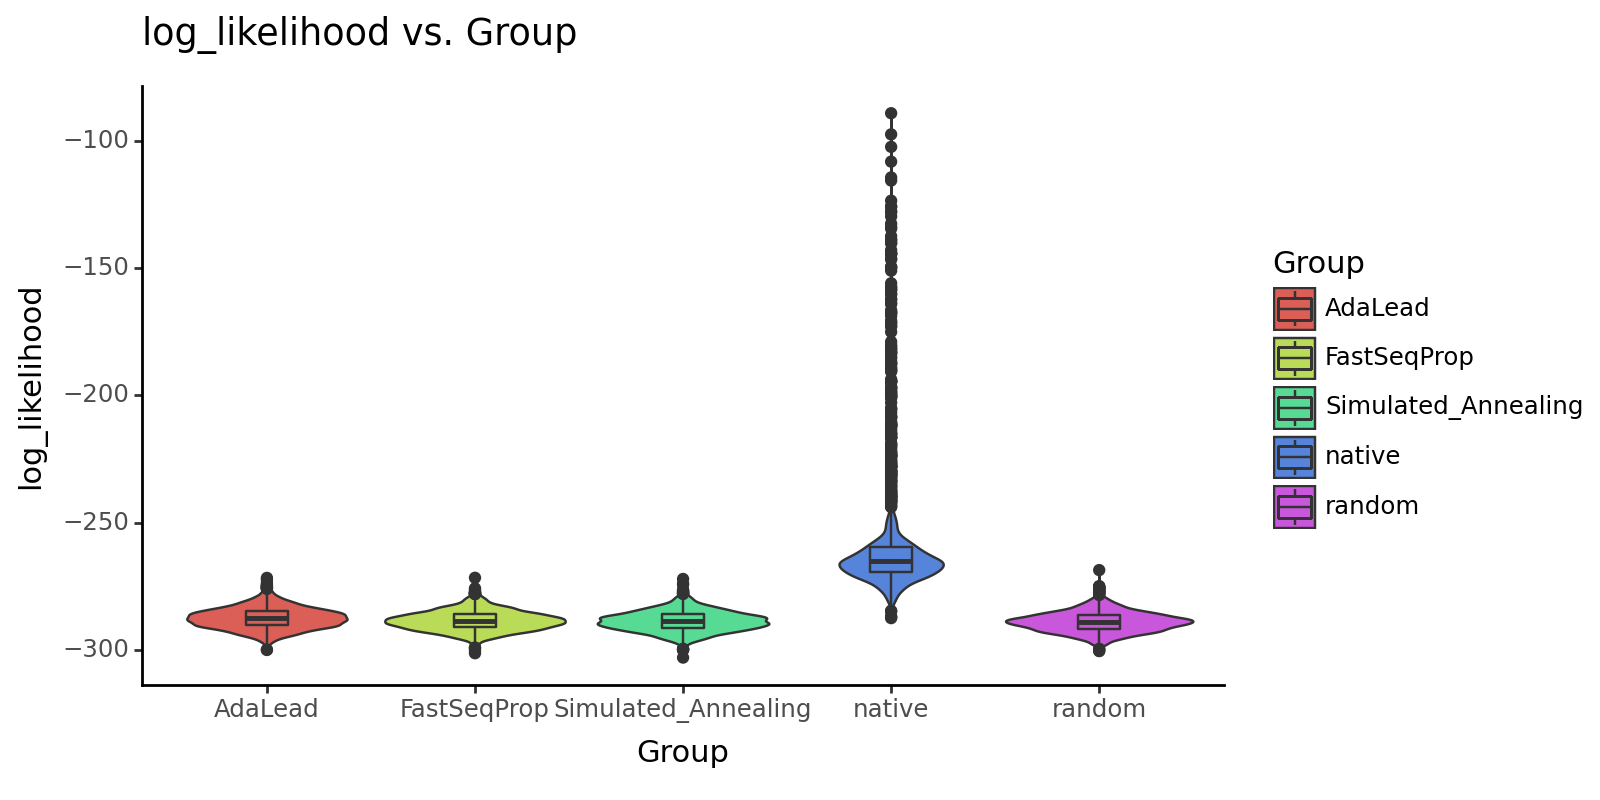

<Figure Size: (800 x 400)>

In [61]:
polygraph.visualize.boxplot(seqs, group_col="Group", value_col="log_likelihood") + p9.theme(figure_size=(8, 4))